In [1]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import pipeline modules
from src.data_processing import load_processed_data
from src.auxiliary import pathology_severity_groups, histogram_labels,analyze_feature_distributions
from ecg_data_pipeline import ECGFeatureExtractor, CardiacConditionClassifier
from ecg_model_pipeline import ECGModelTrainer, ModelVisualizer, BoundaryVisualizer

# Load validation indices
validation_indices_path = './Results/val_indices.npy'
val_indices = np.load(validation_indices_path, allow_pickle=True)

# Load validation data
data_path = './Results/processed_data'
val_ecg_dict, val_data = load_processed_data(data_path, indices=val_indices)
print(f"Loaded validation data for {len(val_data)} patients")

# Extract ECG signals
val_ecg = {k: v['ecg_signals_filtered'] for k, v in val_ecg_dict.items()}
del val_ecg_dict  # Free memory

Loading patient data: 100%|██████████| 13545/13545 [00:37<00:00, 356.55it/s]

2025-02-28 11:38:54 - load_processed_data took 0.63 minutes
Loaded validation data for 13545 patients


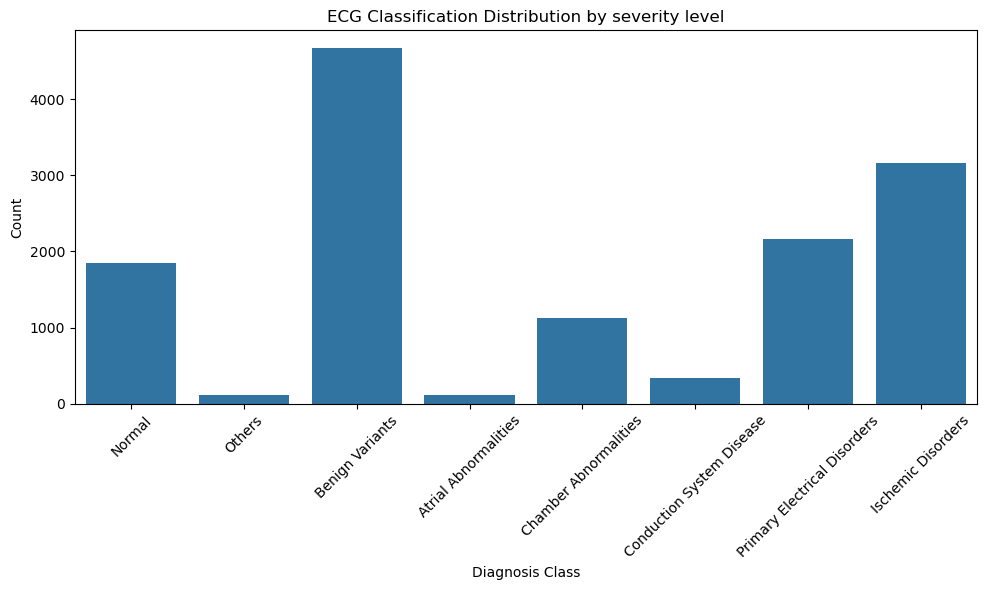

In [2]:
# Initialize condition classifier
condition_classifier = CardiacConditionClassifier(pathology_hierarchy=pathology_severity_groups)

# Transform diagnosis codes into cardiac condition categories
val_data = condition_classifier.transform(val_data)
val_labels = val_data['diagnosis_label']

# Visualize class distribution
pathology_order = sorted(
    pathology_severity_groups.keys(),
    key=lambda cat: pathology_severity_groups[cat]['severity'],
    reverse=False
)
histogram_labels(val_labels, pathology_order=pathology_order)

Error extracting HR metrics for patient JS01019: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS01211: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS03199: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS03809: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS04550: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS06477: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS06965: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS07401: zero-size array to reduction operation minimum which has no identity
Error extracting HR metrics for patient JS07992: zero-si

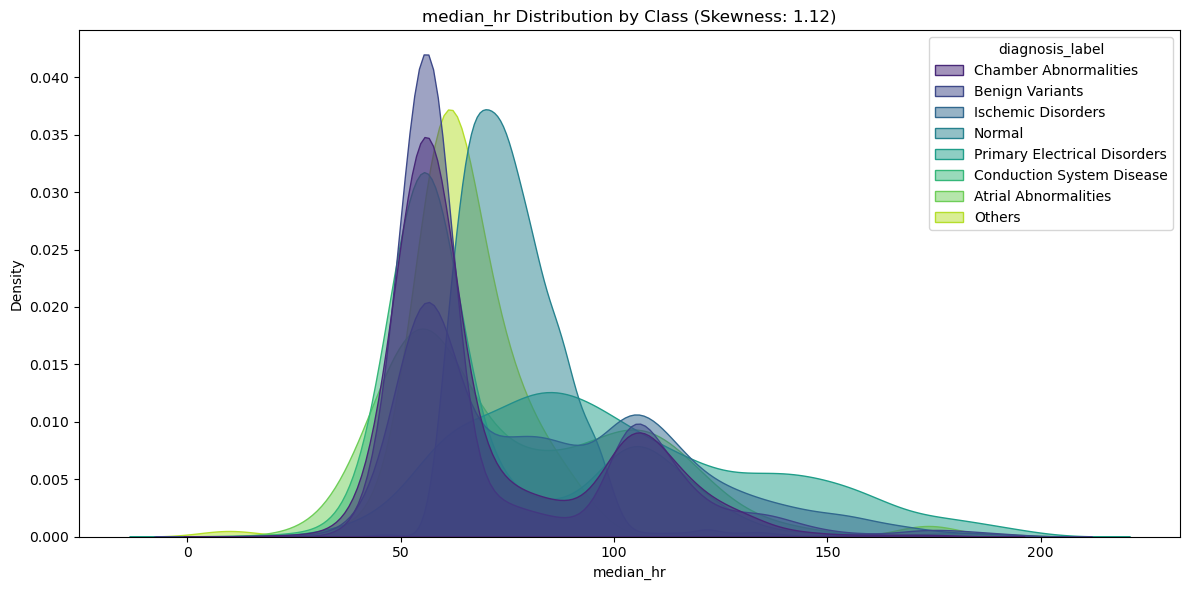

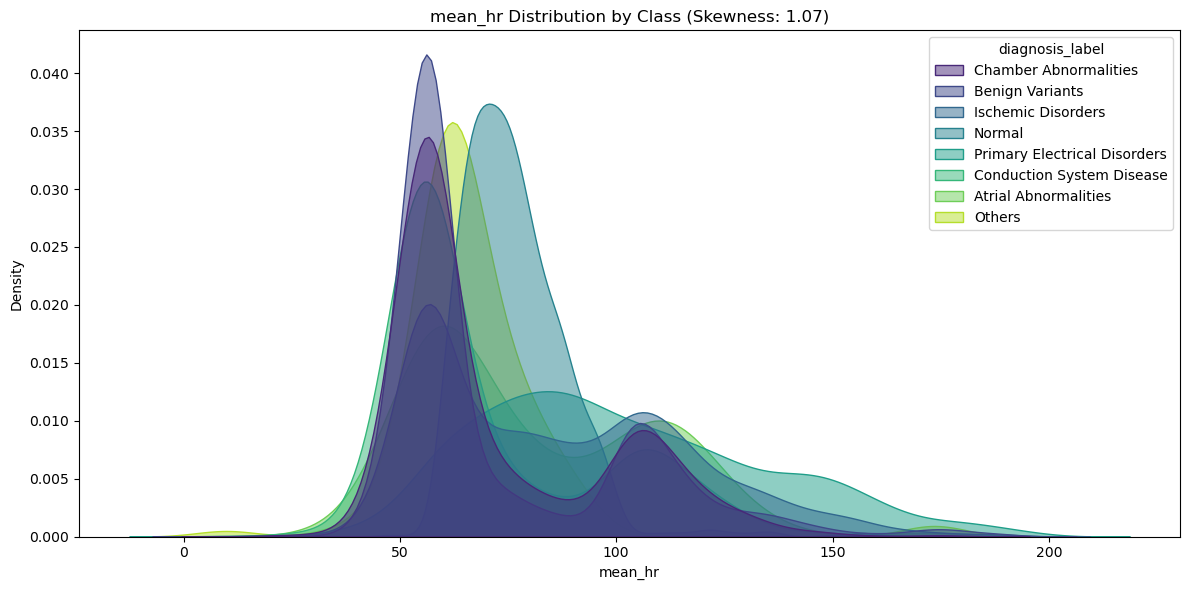

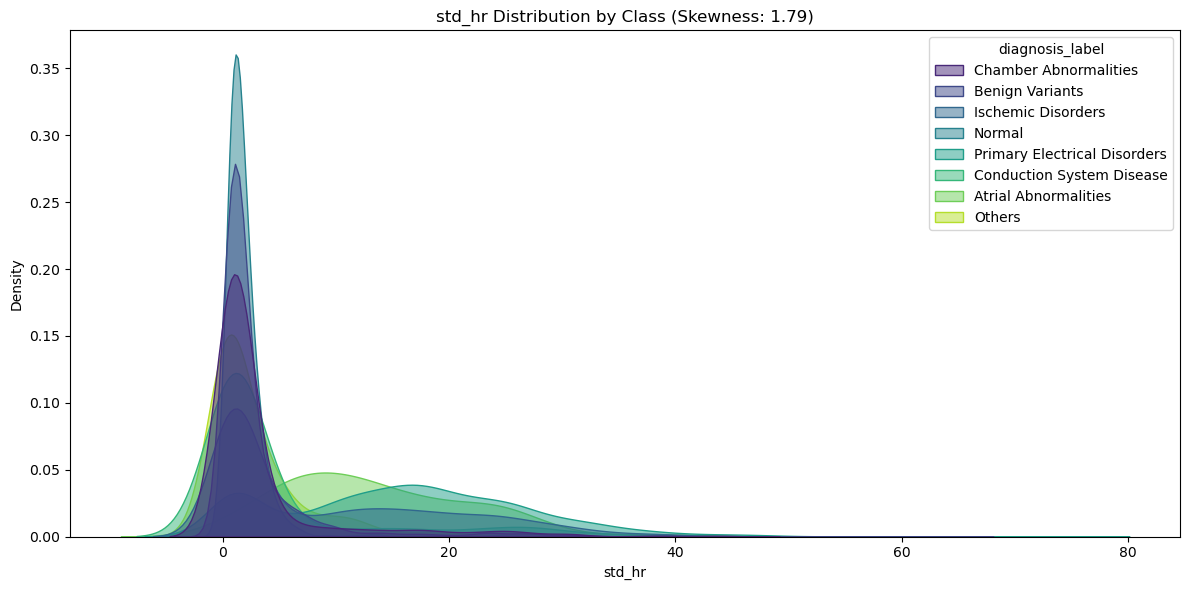

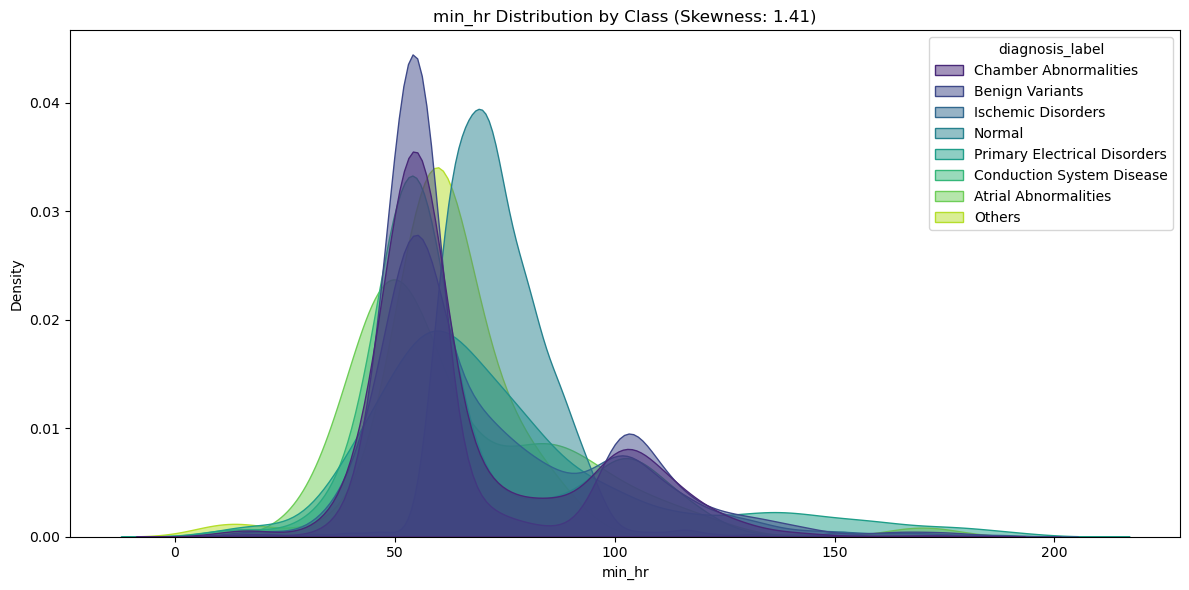

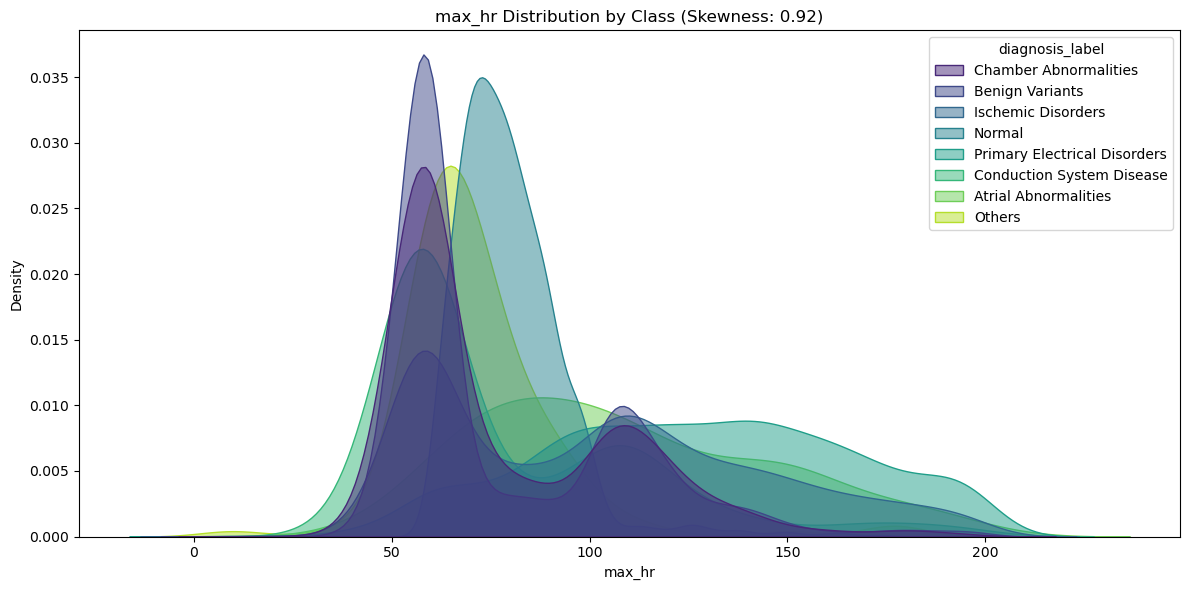

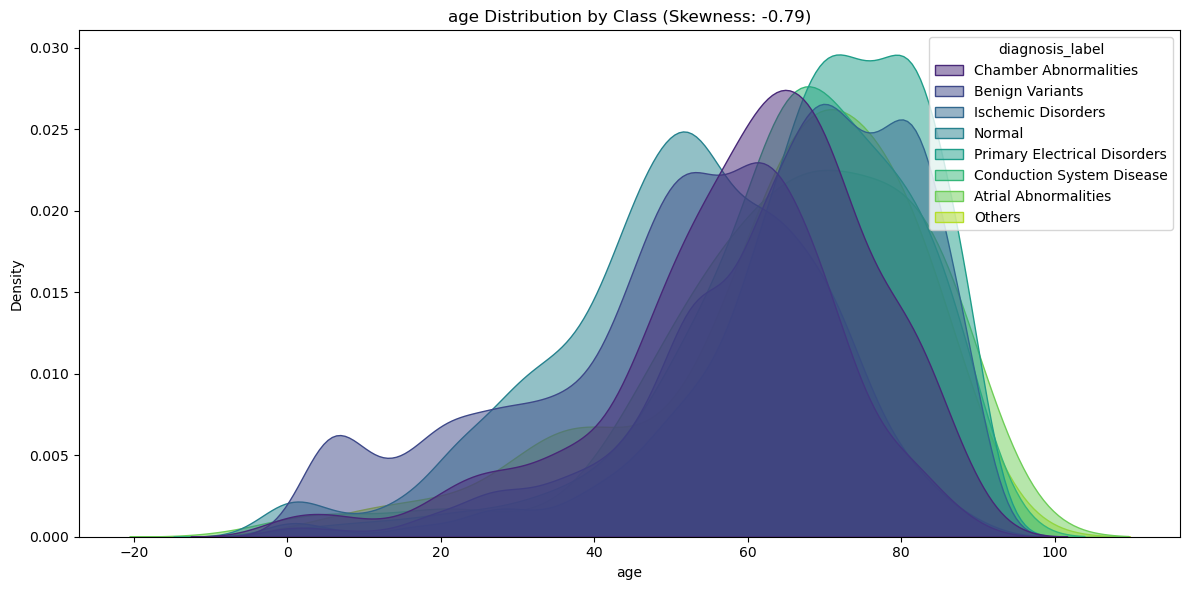

median_hr    1.124714
mean_hr      1.065509
std_hr       1.791796
min_hr       1.414800
max_hr       0.916772
age         -0.792773
dtype: float64

In [3]:
# Initialize feature extractor
feature_extractor = ECGFeatureExtractor(fs=500, features_to_extract=['hr_metrics', 'age'])

# Extract features from ECG data
extracted_features = feature_extractor.transform(val_ecg, val_data)

# Combine with diagnosis label for analysis
val_hrv = val_data[['diagnosis_label']].join(extracted_features)
feature_names = ['median_hr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr', 'age']

# Feature distribution analysis
analyze_feature_distributions(val_hrv, feature_names)

In [4]:
# Load trained model
model_path = './Results/RF_model/ecg_rf_model.joblib'
model_trainer = ECGModelTrainer.load(model_path)
print(f"Loaded model from {model_path}")

# Create feature matrix and prepare for prediction
X_val = val_hrv[feature_names]
X_val_processed = model_trainer._preprocess_features(X_val)

# Get label mapping for evaluation
inv_mapping = {v: k for k, v in model_trainer.label_mapping.items()}
ordered_classes = [inv_mapping[i] for i in range(len(inv_mapping))]
y_val_encoded = np.array([model_trainer.label_mapping.get(label, -1) for label in val_labels])

# Generate predictions
y_pred = model_trainer.predict(X_val)
y_pred_proba = model_trainer.predict_proba(X_val)

Loaded model from ./Results/RF_model/ecg_rf_model.joblib



Confusion Matrix:


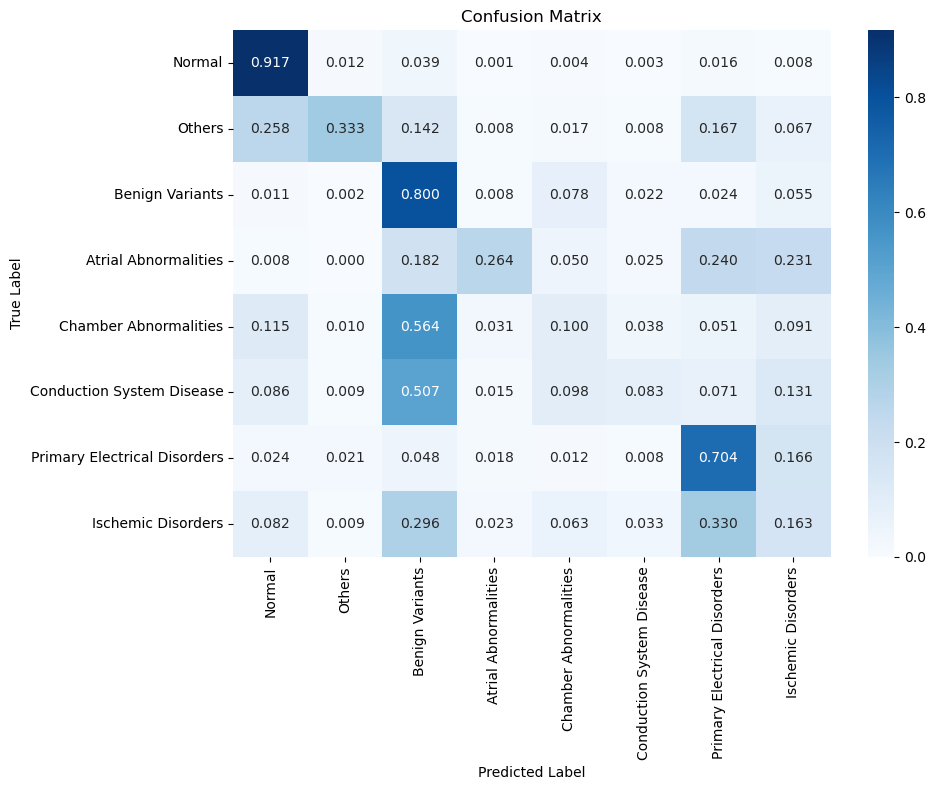


Classification Report with Sensitivity and Specificity:
Class           Sensitivity  Specificity  F1-Score     Support   
------------------------------------------------------------
Normal          0.9169       0.9164       0.7330       1         
Others          0.3333       0.9910       0.4774       1         
Benign Variants 0.8003       0.7460       0.4473       1         
Atrial Abnormalities 0.2645       0.9851       0.3865       1         
Chamber Abnormalities 0.0999       0.9543       0.1407       1         
Conduction System Disease 0.0831       0.9803       0.1361       1         
Primary Electrical Disorders 0.7039       0.8717       0.5410       1         
Ischemic Disorders 0.1633       0.8931       0.1708       1         
------------------------------------------------------------
macro avg       0.4207       0.9172       0.3791       8         
weighted avg    0.4207       0.9172       0.3791       8         

Performance by Age Group:
  Age >65: 0.436 accuracy (5496

In [5]:
# Create visualizer
visualizer = ModelVisualizer()

# Plot confusion matrix
print("\nConfusion Matrix:")
visualizer.plot_multiclass_confusion_matrix(y_val_encoded, y_pred, ordered_classes, normalise=1)

# Create results dataframe with predictions
val_results = val_data.copy()
val_results['true_label_code'] = y_val_encoded
val_results['predicted_label_code'] = y_pred
val_results['true_label'] = [ordered_classes[i] for i in y_val_encoded]
val_results['predicted_label'] = [ordered_classes[i] for i in y_pred]
val_results['correct'] = (y_val_encoded == y_pred).astype(int)

# Age group analysis
val_results['age_group'] = pd.cut(
    val_results['age'], 
    bins=[0, 40, 65, 100], 
    labels=['<40', '40-65', '>65']
)

# Performance by age group
print("\nPerformance by Age Group:")
for age_group in val_results['age_group'].unique():
    group_idx = val_results['age_group'] == age_group
    if np.sum(group_idx) > 0:
        accuracy = np.mean(val_results.loc[group_idx, 'correct'])
        print(f"  Age {age_group}: {accuracy:.3f} accuracy ({np.sum(group_idx)} patients)")

# Performance by cardiac condition
print("\nPerformance by Cardiac Condition:")
for i, condition in enumerate(ordered_classes):
    condition_idx = (y_val_encoded == i)
    if np.sum(condition_idx) > 0:
        accuracy = np.mean(val_results.loc[condition_idx, 'correct'])
        print(f"  {condition}: {accuracy:.3f} accuracy ({np.sum(condition_idx)} patients)")


ROC Curves (One-vs-All):


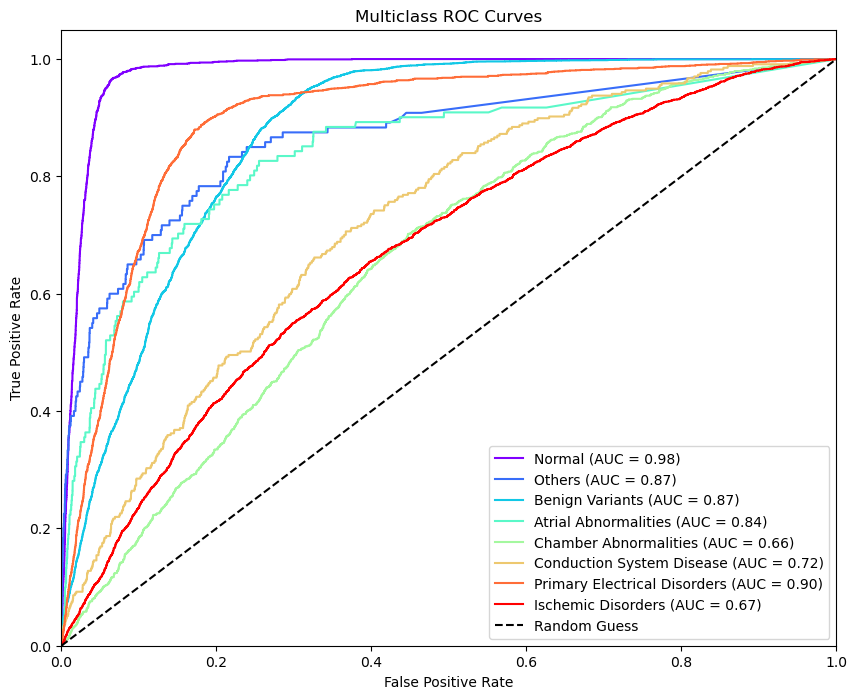


ROC Curves (One-vs-Normal):


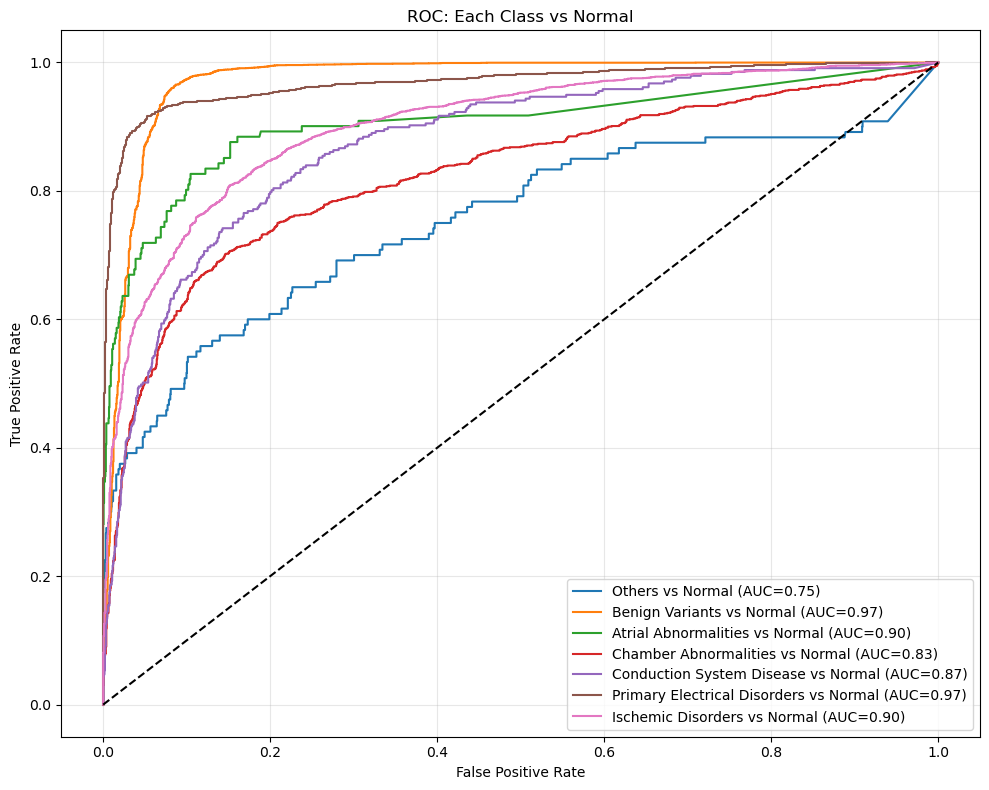


ROC AUC Values:
  Normal: 0.978
  Others: 0.867
  Benign Variants: 0.873
  Atrial Abnormalities: 0.843
  Chamber Abnormalities: 0.659
  Conduction System Disease: 0.721
  Primary Electrical Disorders: 0.897
  Ischemic Disorders: 0.672


In [6]:
# Plot ROC curves for all classes
print("\nROC Curves (One-vs-All):")
roc_auc = visualizer.plot_one_vs_all_multiclass_roc(y_val_encoded, y_pred_proba, ordered_classes)

# Plot ROC curves for each condition vs normal
print("\nROC Curves (One-vs-Normal):")
visualizer.plot_one_vs_normal_roc(y_val_encoded, y_pred_proba, ordered_classes, normal_idx=0)

# Summarize ROC AUC values
print("\nROC AUC Values:")
for i, class_name in enumerate(ordered_classes):
    print(f"  {class_name}: {roc_auc[i]:.3f}")

In [7]:
# Define severity levels
severity_levels = {condition: pathology_severity_groups[condition]['severity'] 
                  for condition in pathology_severity_groups.keys()}

# Add severity to results
val_results['true_severity'] = val_results['true_label'].map(severity_levels)
val_results['predicted_severity'] = val_results['predicted_label'].map(severity_levels)
val_results['severity_error'] = val_results['true_severity'] - val_results['predicted_severity']

# Critical misclassifications: severe conditions predicted as normal or benign
critical_misclass = val_results[
    (val_results['correct'] == 0) & 
    (val_results['true_severity'] >= 5) & 
    (val_results['predicted_severity'] <= 2)
]

print("\nCritical Misclassifications (High Severity as Normal/Benign):")
print(f"Total: {len(critical_misclass)} patients ({len(critical_misclass)/len(val_results):.1%} of validation set)")


Critical Misclassifications (High Severity as Normal/Benign):
Total: 1631 patients (12.0% of validation set)



Visualizing decision boundaries in PCA space:


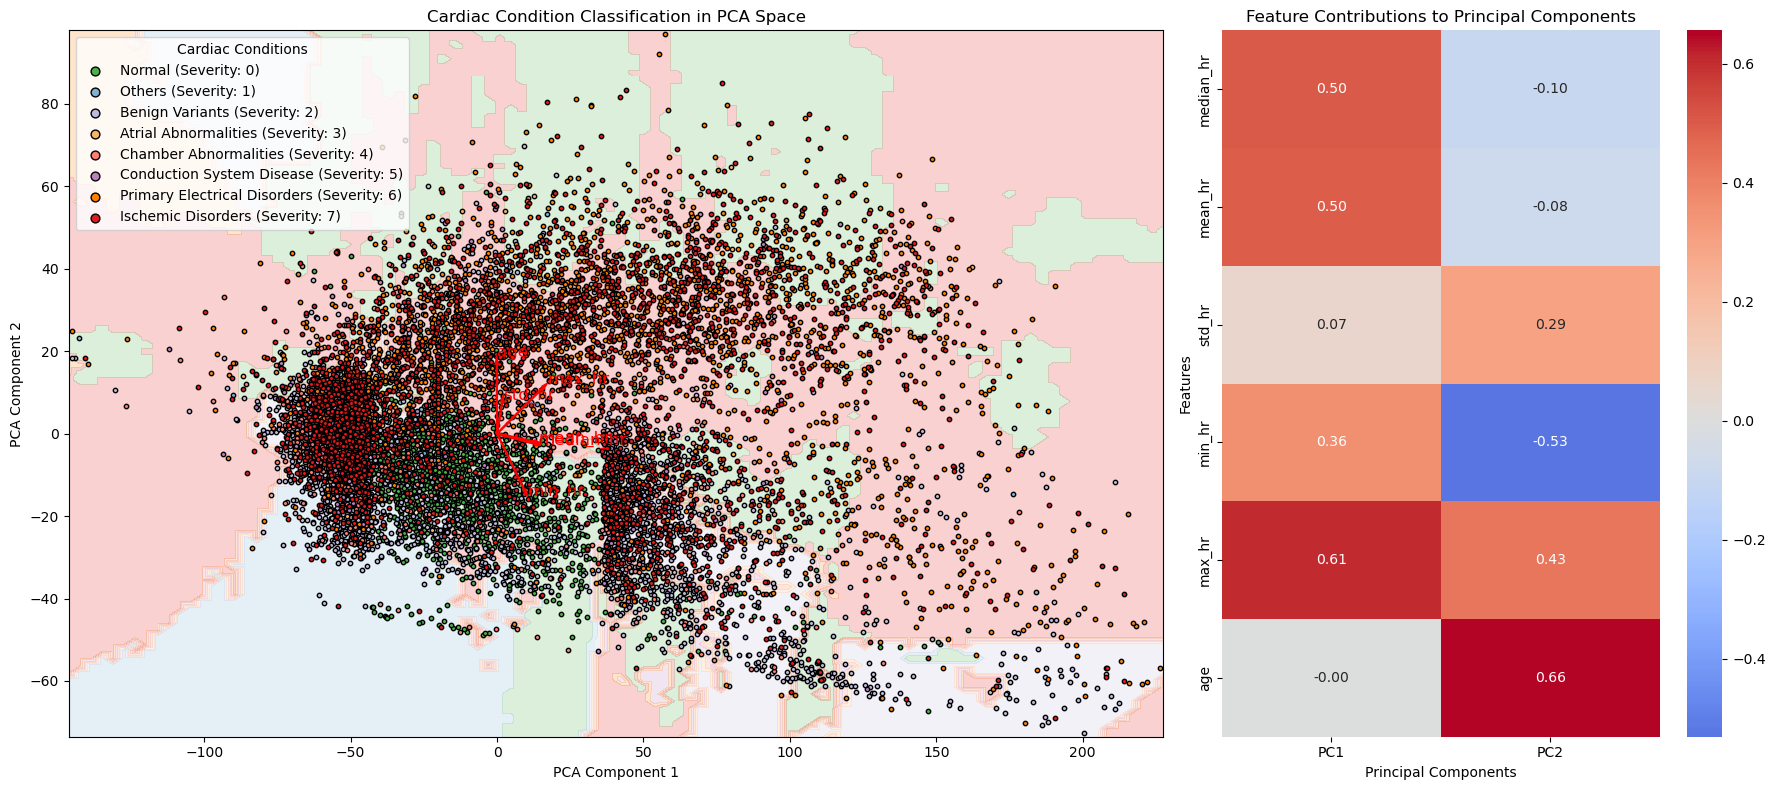

(array([[-50.4679436 ,   5.35301735],
        [-34.58952033,   4.55602307],
        [-62.93282949,   6.60340695],
        ...,
        [131.53393097, -64.05202816],
        [170.86319142,  16.6316149 ],
        [ 58.14518307, -21.0675868 ]]),
 array([[ 0.50145574,  0.49556572,  0.06660348,  0.36258216,  0.60583636,
         -0.00414786],
        [-0.09578191, -0.07636043,  0.29450261, -0.53094547,  0.4316159 ,
          0.65579551]]))

In [8]:
# Visualize decision boundaries in PCA space
print("\nVisualizing decision boundaries in PCA space:")
BoundaryVisualizer.plot_decision_space(
    X_val_processed, 
    y_val_encoded, 
    model_trainer.model, 
    ordered_classes, 
    binary=False
)

In [9]:
# Save validation summary
output_dir = './Results/validation'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, 'validation_summary.txt'), 'w') as f:
    f.write("ECG Classification Model Validation\n")
    f.write("===================================\n\n")
    
    f.write(f"Validation set size: {len(val_indices)} patients\n")
    
    f.write("\nPerformance Metrics:\n")
    f.write("--------------------------\n")
    # Calculate overall metrics
    accuracy = np.mean(y_val_encoded == y_pred)
    f.write(f"Overall accuracy: {accuracy:.4f}\n")
    
    # Class-specific metrics
    f.write("\nClass-specific performance:\n")
    for i, cls_name in enumerate(ordered_classes):
        class_mask = (y_val_encoded == i)
        if np.sum(class_mask) > 0:
            cls_acc = np.mean(y_pred[class_mask] == i)
            f.write(f"  {cls_name}: {cls_acc:.4f} (n={np.sum(class_mask)})\n")
    
    # Critical errors
    f.write(f"\nCritical misclassifications: {len(critical_misclass)} ({len(critical_misclass)/len(val_results):.1%} of validation set)\n")
    
    f.write("\nROC AUC Values:\n")
    for i, class_name in enumerate(ordered_classes):
        f.write(f"  {class_name}: {roc_auc[i]:.4f}\n")

print(f"\nValidation results saved to {output_dir}")


Validation results saved to ./Results/validation


# Final Conclusions

## Model Performance
- **Consistency**: Similar metrics between development and validation datasets (generalization confirmed)
- **Overall accuracy**: ~60% with better AUC (~0.80) than precision/recall (~0.40)
- **Age-dependent performance**: Best in 40-65 age group, worse in >65 patients

## Strengths
- **Normal ECG detection**: High sensitivity (~92%) across datasets
- **Primary Electrical Disorders**: Good detection (~70-72%)
- **Normal vs. Abnormal**: Strong discrimination (all conditions vs. Normal AUCs ≥0.83 except "Others", which are pacemakers mainly)

## Critical Weaknesses
- **Dangerous misclassifications**: 12% of high-severity conditions misclassified as normal/benign
- **Conduction System Disease**: 60.2% misclassified as benign/normal
- **Ischemic Disorders**: 38.8% misclassified as benign/normal (8.2% as Normal)
- **Poor discrimination**: Chamber Abnormalities (AUC 0.66-0.67) and Ischemic Disorders (AUC 0.67-0.68)

## Feature Analysis
- **Importance ranking**: std_hr > mean_hr > median_hr > age > max_hr > min_hr
- **Feature stability**: High rank stability (0.88)
- **PCA projection**: Significant class overlap with PC1 driven by HR metrics, PC2 by age
- **Feature insufficiency**: Current features inadequate for morphologically distinct conditions

## Future Implementations
1. Implement ECG morphology features (PR intervals, QRS width, ST elevation) and frequency domain features
2. Adopt hierarchical classification (normal/abnormal first, then specific condition)
3. Apply class balancing techniques for minority classes
4. Develop condition-specific classification thresholds
5. Implement age-stratified models to address elderly performance gap

The current model confirms limitations identified in main.ipynb: insufficient features, imbalanced data, and clinically unacceptable misclassifications of high-severity conditions.
"""